### Importing helper functions, modules, and data

Load the helper functions and the data.

In [1]:
from components import load_parquet_data
import pandas as pd
import numpy as np

### Importing the Data

### Exploring the language specific data

In [2]:
# print("All Unique Languages", content['language'].unique())

# df = content[content['language'] == 'ur']
# df.head(100)

correlations = load_parquet_data("input/correlations.parquet")
correlations.head(100)

# topics = load_parquet_data("input/topics.parquet")
# topics[topics['language'] == 'en'].head(100)

,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d c_376c5a8eb028 c_5bc0e1e2cba0 c...
1,t_00068291e9a4,c_639ea2ef9c95 c_89ce9367be10 c_ac1672cdcd2c c...
2,t_00069b63a70a,c_11a1dc0bfb99
3,t_0006d41a73a8,c_0c6473c3480d c_1c57a1316568 c_5e375cf14c47 c...
4,t_0008768bdee6,c_34e1424229b4 c_7d1a964d66d5 c_aab93ee667f4
...,...,...
95,t_00703e555d28,c_3fe13ff4b47f c_8d897997b1b7 c_a223a6d099e0 c...
96,t_00764f7c9394,c_0c298c9fb121 c_1d93f4a9aa15 c_24839b8434d7 c...
97,t_007973177106,c_4fb17d71ae87 c_d1a3481c3ce3 c_e2bfed90d2cf c...
98,t_0079b3319fb5,c_3c105d8e600c c_7dd250694a6f c_7e44fda51c46 c...


### Exploratory Data Analysis 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import display, Markdown
from pathlib import Path

current_path = Path.cwd()

# Various directories

data_dir = current_path / "input"
output_dir = current_path / "output"

### Load the data

In [4]:
# load the data into pandas dataframes
# topics_df = pd.read_csv(data_dir / "topics.csv", index_col=0).fillna({"title": "", "description": ""})
# content_df = pd.read_csv(data_dir / "content.csv", index_col=0).fillna("")
# correlations_df = pd.read_csv(data_dir / "correlations.csv", index_col=0)

topics_df = load_parquet_data(data_dir/'topics.parquet')
topics_df.index_col = 0
topics_df = topics_df.fillna({"title": "", "description": ""})

# Content is stored as a string of comma separated values

content_df = load_parquet_data(data_dir/'content.parquet')
content_df.index_col = 0
content_df = content_df.fillna("")

# Correlations are stored as a string of comma separated values

correlations_df = load_parquet_data(data_dir/'correlations.parquet')
correlations_df.index_col = 0


In [5]:
## select only english topics and level 0
## also count unique topics

topics_df[(topics_df.language == "en") & (topics_df.level == 1)].nunique()



id             465
title          390
description    153
channel         90
category         3
level            1
language         1
parent          90
has_content      2
dtype: int64

### Work with 10% of the data

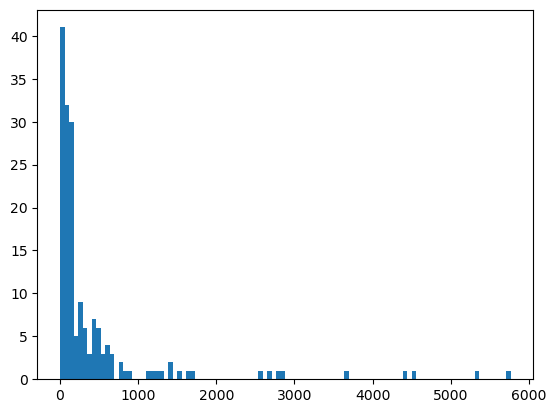

In [6]:
# show a random sample of the content from the content dataframe
content_df.sample(frac=1).head(10)
topics_df.sample(frac=1).head(10)

# top languages by number of topics
topics_df.language.value_counts().sort_values(ascending=False).head(10)

# top languages by number of content items
content_df.language.value_counts().sort_values(ascending=False).head(10)

# numbers of different types of content
content_df.kind.value_counts().sort_values(ascending=False).head(10)

# sizes of different channels (in terms of numbers of topics)
plt.hist(topics_df.channel.value_counts(), bins=100)
plt.show()


### Helper Functions

In [7]:
# define some helper functions and classes to aid with data traversal

def print_markdown(md):
    display(Markdown(md))

class Topic:
    def __init__(self, topic_id):
        self.id = topic_id

    @property
    def parent(self):
        parent_id = topics_df.loc[self.id].parent
        if pd.isna(parent_id):
            return None
        else:
            return Topic(parent_id)

    @property
    def ancestors(self):
        ancestors = []
        parent = self.parent
        while parent is not None:
            ancestors.append(parent)
            parent = parent.parent
        return ancestors

    @property
    def siblings(self):
        if not self.parent:
            return []
        else:
            return [topic for topic in self.parent.children if topic != self]

    @property
    def content(self):
        if self.id in correlations_df.index:
            return [ContentItem(content_id) for content_id in correlations_df.loc[self.id].content_ids.split()]
        else:
            return tuple([]) if self.has_content else []

    def get_breadcrumbs(self, separator=" >> ", include_self=True, include_root=True):
        ancestors = self.ancestors
        if include_self:
            ancestors = [self] + ancestors
        if not include_root:
            ancestors = ancestors[:-1]
        return separator.join(reversed([a.title for a in ancestors]))

    @property
    def children(self):
        return [Topic(child_id) for child_id in topics_df[topics_df.parent == self.id].index]

    def subtree_markdown(self, depth=0):
        markdown = "  " * depth + "- " + self.title + "\n"
        for child in self.children:
            markdown += child.subtree_markdown(depth=depth + 1)
        for content in self.content:
            markdown += ("  " * (depth + 1) + "- " + "[" + content.kind.title() + "] " + content.title) + "\n"
        return markdown

    def __eq__(self, other):
        if not isinstance(other, Topic):
            return False
        return self.id == other.id

    def __getattr__(self, name):
        return topics_df.loc[self.id][name]

    def __str__(self):
        return self.title
    
    def __repr__(self):
        return f"<Topic(id={self.id}, title=\"{self.title}\")>"


class ContentItem:
    def __init__(self, content_id):
        self.id = content_id

    @property
    def topics(self):
        return [Topic(topic_id) for topic_id in topics_df.loc[correlations_df[correlations_df.content_ids.str.contains(self.id)].index].index]

    def __getattr__(self, name):
        return content_df.loc[self.id][name]

    def __str__(self):
        return self.title
    
    def __repr__(self):
        return f"<ContentItem(id={self.id}, title=\"{self.title}\")>"

    def __eq__(self, other):
        if not isinstance(other, ContentItem):
            return False
        return self.id == other.id

    def get_all_breadcrumbs(self, separator=" >> ", include_root=True):
        breadcrumbs = []
        for topic in self.topics:
            new_breadcrumb = topic.get_breadcrumbs(separator=separator, include_root=include_root)
            if new_breadcrumb:
                new_breadcrumb = new_breadcrumb + separator + self.title
            else:
                new_breadcrumb = self.title
            breadcrumbs.append(new_breadcrumb)
        return breadcrumbs



### Tree Structures

count    61517.000000
mean         4.550271
std          6.700255
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max        293.000000
dtype: float64

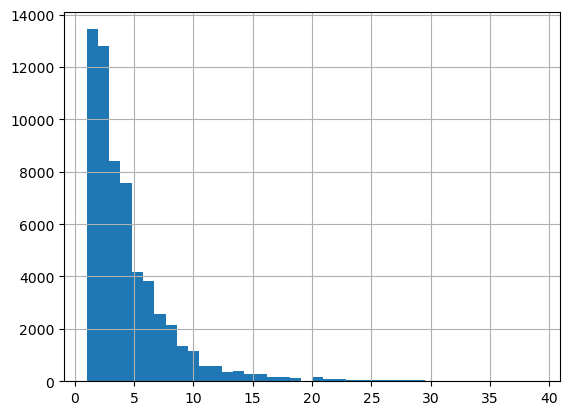

In [9]:
# how many content items are correlated with each topic?
content_per_topic = pd.Series([len(cids.split()) for cids in correlations_df.content_ids])
content_per_topic[content_per_topic < 40].hist(bins=40)
content_per_topic.describe()